In [88]:
import librosa
import numpy as np
import pandas as pd
from datetime import timedelta
import glob
import natsort
import pandas as pd
import numpy as np
import math
import os
import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D,BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from datetime import timedelta

from keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [11]:
def visualize(path: str):
    
 
    raw = wave.open(path)
    Audio(path)  
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
      
    # gets the frame rate
    f_rate = raw.getframerate()
  
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
      
    )
    Audio(path)
   
  
    # using matlplotlib to plot
    # creates a new figure
    plt.figure(1)
      
    # title of the plot
    plt.title(path.split('_')[2])
      
    # label of x-axis
    plt.xlabel("Time")
     
    # actual ploting
    plt.plot(time, signal)
      
    # shows the plot 
    # in new window
    plt.show()
  
    # you can also save
    # the plot using
    # plt.savefig('filename')
  

In [12]:
def createFileList(format='.wav'):
    fileList = []
    #print(/content/Crema)
    for root, dirs, files in os.walk('/Users/omarkhaled/Documents/pr/Crema', topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList



In [13]:
fileList = createFileList()
Emotions=['HAP','DIS','FEA','NEU','SAD','ANG']
Emotions=np.array(Emotions)
#print(fileList[0].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+Emotions[0]+'_'+'XX.wav')
for feel in Emotions:
  path=fileList[1500].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+feel+'_'+'XX.wav'
  #path='1001'+'_'+'DFA'+'_'+feel+'_'+'XX.wav'

  # visualize(path)
 
 
 

In [ ]:
audio = tfio.audio.AudioIOTensor(fileList[0])
audio=audio.to_tensor()
tensor = tf.cast(audio, tf.float32) / 32768.0
print(audio.shape)



(47514, 1)


In [14]:
onehot_encoded_data=[]
for i in fileList:
  onehot_encoded_data.append([i.split('_')[2]])
emotion_df = pd.DataFrame( onehot_encoded_data , columns=['Emotions'] )

# dataframe for path of files.
path_df = pd.DataFrame(fileList, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


onehot_encoded_data=np.array(onehot_encoded_data)
encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = encoder.fit_transform(onehot_encoded_data)




In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


    

In [16]:
def shortTermEnergy(frame):
  return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [17]:
def zeroCrossingRate(frame):
  signs             = numpy.sign(frame)
  signs[signs == 0] = -1

  return len(numpy.where(numpy.diff(signs))[0])/len(frame)

In [45]:
def extract_features(data,sample_rate):

    # ZCR
    result = np.array([])

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    #spectral centroid
    cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, cent))
    
    #spectral bandwidth
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T,axis = 0)
    result = np.hstack((result, spec_bw))


    #spectral flattness
    flatness = np.mean(librosa.feature.spectral_flatness(y=data).T,axis=0)
    result = np.hstack((result, flatness))

    return result


In [47]:
def get_features(path, augment):
    # duration and offset are used to take care of the no audivvo in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)#, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
 
    result = np.array(res1)
    
    if augment:
        # data with noise
        noise_data = noise(data)
        
        res2 = extract_features(noise_data,sample_rate)
        
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        
        data_stretch_pitch = pitch(new_data, sample_rate)
        
        res3 = extract_features(data_stretch_pitch,sample_rate)
        
        result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [48]:
##function generate mel spectogram for read audio 
def get_mel_wav(data,sr):
  mel_spectrogram = librosa.feature.melspectrogram(data, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [49]:
##splitting thDS to test,train,val and specifing batch_size,epochs,num_classes
X1_train, X1_test, y1_train, y1_test = train_test_split( fileList, onehot_encoded_data, test_size=0.3, random_state=42,shuffle='Yes')
X1_trainfinal, X1_vaildate, y1_trainfinal, y1_validate = train_test_split( X1_train, y1_train, test_size=0.05, random_state=42,shuffle='Yes')

batch_size = 128
epochs = 50
num_classes = 6


In [50]:
X_train = X1_trainfinal
y_train = y1_trainfinal

In [ ]:
X, Y = [], []
X_train=np.array(X_train)
i =0
runs =100
for path, emotion in zip(X_train,y_train):
    if i%runs == 0:
        print(i)
    feature = get_features(path,True)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    i+=1

In [52]:
X_train_features = np.array(X)
y_train_features = np.array(Y)
print(X_train_features.shape,y_train_features.shape)

(14844, 35) (14844, 6)


In [53]:
X_test = X1_test
y_test = y1_test
X_validate = X1_vaildate
y_validate = y1_validate

In [54]:
X2, Y2 = [], []
X_test=np.array(X_test)
for path, emotion in zip(X_test,y_test):
    feature = get_features(path,False)
    X2.append(feature)
    Y2.append(emotion)

In [55]:
X3, Y3 = [], []
X_validate=np.array(X_validate)

for path, emotion in zip(X_validate,y_validate):
    feature = get_features(path,False)
    X3.append(feature)
    Y3.append(emotion)
        
   

In [56]:
X_test_features = np.array(X2)
y_test_features = np.array(Y2)
X_validate_features = np.array(X3)
y_validate_features = np.array(Y3)

In [57]:
X_train_features = X_train_features[:,:,np.newaxis]

X_test_features  = X_test_features[:,:,np.newaxis]

X_validate_features = X_validate_features[:,:,np.newaxis]



In [58]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)


(14844, 35, 1) (14844, 6) (2233, 35, 1) (2233, 6) (261, 35, 1) (261, 6)


In [59]:
with open('features_freq.npy', 'wb') as f:
    np.save(f, X_train_features)
    np.save(f, y_train_features)

    np.save(f, X_test_features)
    np.save(f, y_test_features)

    np.save(f, X_validate_features)
    np.save(f, y_validate_features)


In [76]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(encoder, f)

In [2]:
#reading the data set feom the npy file
import numpy as np
X_train_features = None
y_train_features = None
X_test_features =None
y_test_features = None
X_validate_features = None
y_validate_features = None

with open('features.npy', 'rb') as f:
    X_train_features = np.load(f)
    y_train_features = np.load(f)
    X_test_features = np.load(f)
    y_test_features = np.load(f)
    X_validate_features = np.load(f)
    y_validate_features = np.load(f)


In [60]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)

(14844, 35, 1) (14844, 6) (2233, 35, 1) (2233, 6) (261, 35, 1) (261, 6)


In [175]:
model=Sequential()

model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(X_train_features.shape[1], 1),use_bias= True))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(Conv1D(512, kernel_size=5, strides=2, padding='same', activation='relu',use_bias= True))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))


model.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Flatten())

model.add(Dense(units=512, activation='relu',use_bias= True))


model.add(Dense(units=6, activation='softmax'))

opt = optimizers.Adam(
  lr = 0.0001
)

model.compile(optimizer=opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 35, 512)           4096      
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 18, 512)           0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 9, 512)            1311232   
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 5, 512)            0         
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 3, 128)            196736    
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 1, 64)           

In [176]:

es = EarlyStopping(monitor='val_loss',patience= 20 , mode='min', verbose=1)
history=model.fit(X_train_features, y_train_features, batch_size=128, epochs=300, validation_data=(X_validate_features, y_validate_features),callbacks=[es])


Epoch 1/300
  1/116 [..............................] - ETA: 39s - loss: 2.0964 - accuracy: 0.1719

2021-07-12 23:42:35.134119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 5s 44ms/step - loss: 1.7607 - accuracy: 0.2221 - val_loss: 1.6716 - val_accuracy: 0.3985
Epoch 2/300
  1/116 [..............................] - ETA: 5s - loss: 1.7131 - accuracy: 0.3359

2021-07-12 23:42:40.230021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


116/116 [==============================] - 5s 43ms/step - loss: 1.6501 - accuracy: 0.3048 - val_loss: 1.5214 - val_accuracy: 0.4023
Epoch 3/300
116/116 [==============================] - 5s 42ms/step - loss: 1.5916 - accuracy: 0.3254 - val_loss: 1.5335 - val_accuracy: 0.3755
Epoch 4/300
116/116 [==============================] - 5s 43ms/step - loss: 1.5554 - accuracy: 0.3384 - val_loss: 1.4753 - val_accuracy: 0.3755
Epoch 5/300
116/116 [==============================] - 5s 43ms/step - loss: 1.5254 - accuracy: 0.3551 - val_loss: 1.4944 - val_accuracy: 0.3985
Epoch 6/300
116/116 [==============================] - 5s 43ms/step - loss: 1.5296 - accuracy: 0.3510 - val_loss: 1.4550 - val_accuracy: 0.4138
Epoch 7/300
116/116 [==============================] - 5s 43ms/step - loss: 1.5082 - accuracy: 0.3646 - val_loss: 1.4445 - val_accuracy: 0.4368
Epoch 8/300
116/116 [==============================] - 5s 43ms/step - loss: 1.5054 - accuracy: 0.3632 - val_loss: 1.4636 - val_accuracy: 0.4100
Epoc

In [177]:
test_eval = model.evaluate(X_test_features, y_test_features, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.3940216302871704
Test accuracy: 0.4236453175544739


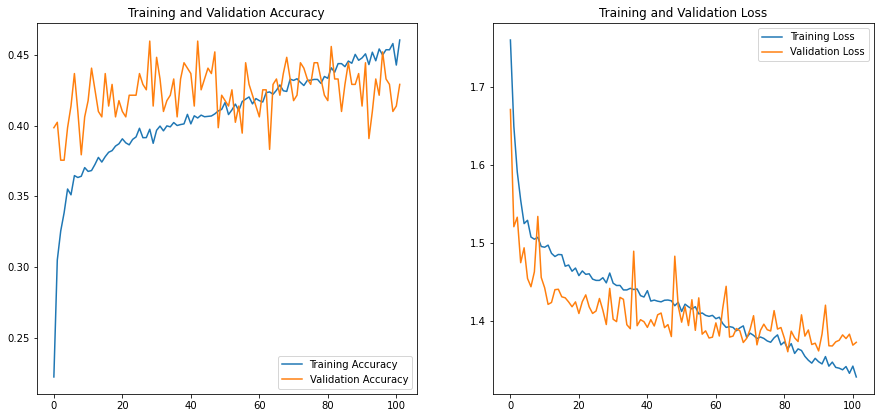

In [179]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(102)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [181]:
# predicting on test data.
pred_test = model.predict(X_test_features)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test_features)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,ANG,ANG
1,NEU,SAD
2,NEU,HAP
3,NEU,SAD
4,SAD,SAD
5,NEU,DIS
6,SAD,DIS
7,FEA,FEA
8,NEU,NEU
9,SAD,SAD


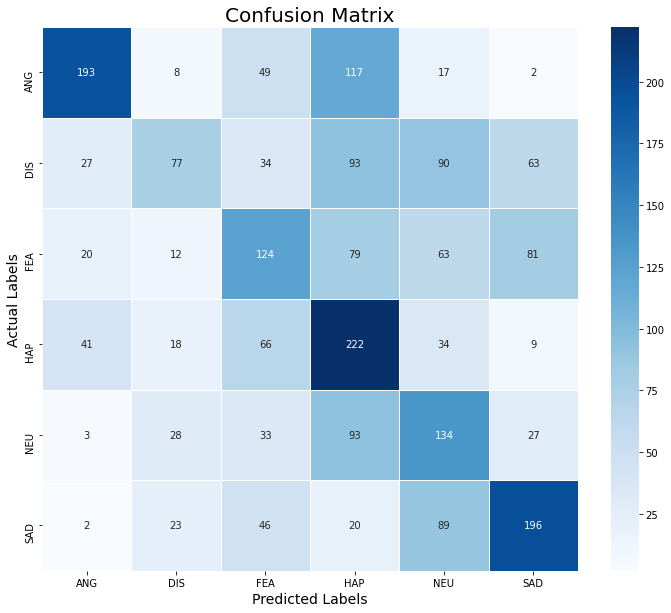

In [182]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()